# Segmentation encoding

This notebook can be used for understanding how input and labels are encoded in segmentation based models

In [1]:
%cd ..
#%matplotlib notebook

/home/romet/projects/ut/milrem/global_planner


In [2]:
import rasterio
import rasterio.plot

import matplotlib.pyplot as plt
from pyproj import Proj, transform
import yaml
from torchvision import transforms

#from data.dataset import MilremVizDataset
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import time
from data.mapping import MapReader


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True, precision=4)


%load_ext autoreload
%autoreload 2



In [3]:
with open("config/env.yaml", "r") as f:
    env_config = yaml.safe_load(f)

map_root_path = env_config["map_path"]
dataset_root_path = env_config["dataset_path"]

map_type = "baseelev"
#map_type = "orienteering"

# val
#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-05-11-17-08-21")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Kärgandi_{map_type}.tif"

#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-08-08-16-37-28")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Hatiku_{map_type}.tif"

#dataset_dir = Path(f"{dataset_root_path}/2023-08-25-15-48-47")
#map_path = f"{map_root_path}/Ihaste_{map_type}.tif"

dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-07-21-11-52-18")
map_path = f"/home/romet/projects/ut/milrem/maps/utm/Supilinn_{map_type}.tif"

# dev
#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-08-21-15-17-51")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Ilmatsalu_{map_type}.tif"

#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-05-25-16-33-18")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Kirikuküla_{map_type}.tif"

#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-05-18-16-40-47")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Tehvandi_{map_type}.tif"

#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-04-20-17-33-33")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Apteekri_{map_type}.tif"

#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-06-13-15-49-17")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Piigaste_{map_type}.tif"

#dataset_dir = Path("/home/romet/data2/datasets/extracted_datasets/2023-08-23-15-21-21")
#map_path = f"/home/romet/projects/ut/milrem/maps/utm/Ihaste_{map_type}.tif"

In [4]:
with open("config/default_segment.yaml", "r") as f:
    config = yaml.safe_load(f)

## Segmentation masks

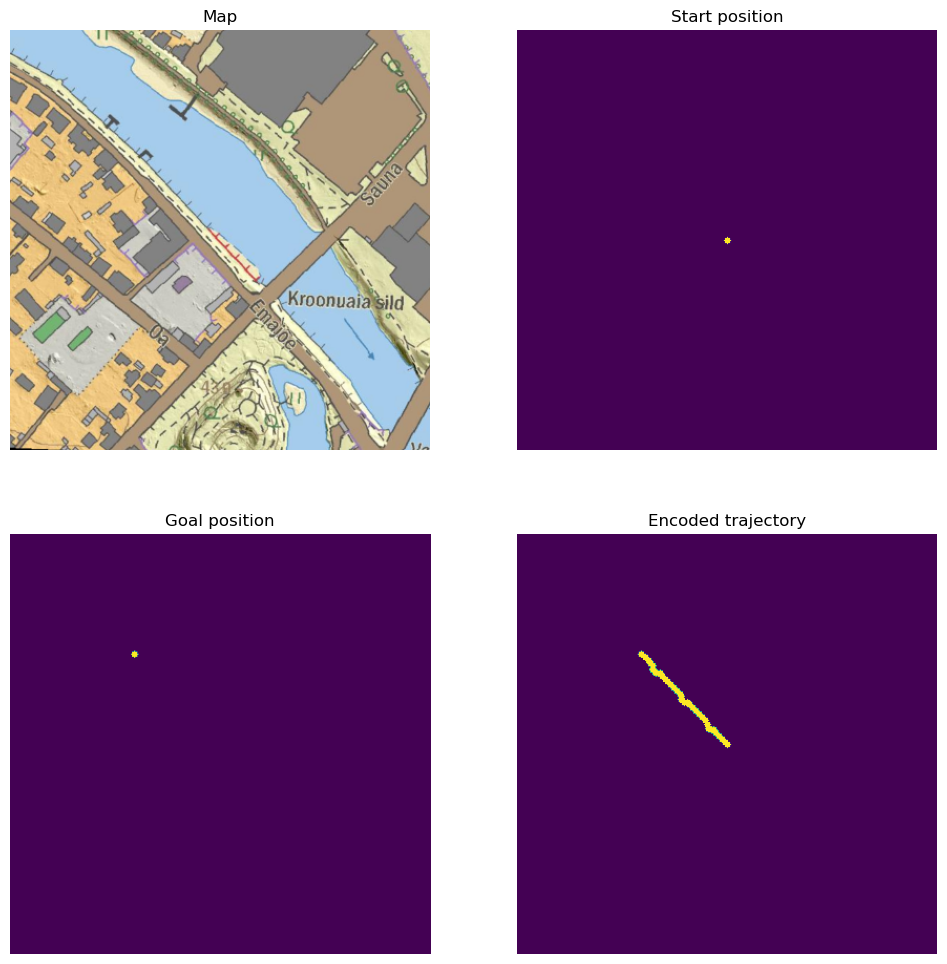

In [5]:
from data.dataset import TrajectoryDataset, NegativeSamplingDataset, OneHotEncodedDataset
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from models.util import load_model


map_reader = MapReader(map_path, config["map_size"])
trajectory_length = 40
config["mask_type"] = "simple" # "simple", "gaussian", "distance", "gaussian-distance"
config["distance_threshold"] = 3

segment_dataset = OneHotEncodedDataset(dataset_path=dataset_dir, 
                                       map_reader=map_reader,
                                       map_size=config['map_size'],
                                       trajectory_min_len=trajectory_length,
                                       trajectory_max_len=trajectory_length,
                                       trajectory_sampling_rate=config['trajectory_sampling_rate'],
                                       config=config)

masked_map, trajectory_mask, trajectory, map_img = segment_dataset[0]


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].imshow(map_img);
axs[0, 0].axis('off');
axs[0, 0].set_title("Map")

axs[0, 1].imshow(masked_map[3]);
axs[0, 1].axis('off');
axs[0, 1].set_title("Start position")

axs[1, 0].imshow(masked_map[4]);
axs[1, 0].axis('off')
axs[1, 0].set_title("Goal position");

axs[1, 1].imshow(trajectory_mask);
axs[1, 1].axis('off');
axs[1, 1].set_title("Encoded trajectory");

## Tuning gaussian parameters

In [6]:
import torch
import torch.nn.functional as F

from data.mask import create_gaussian_mask

simple_dataset = OneHotEncodedDataset(Path(dataset_dir),
                                      map_reader,
                                      map_size=config["map_size"],
                                      trajectory_min_len=config['trajectory_max_length'],
                                      trajectory_max_len=config['trajectory_max_length'],
                                      trajectory_sampling_rate=config['trajectory_sampling_rate'],
                                      config=config)
_, simple_trajectory_mask, _, _ = simple_dataset[50]

@interact(kernel_size=widgets.IntSlider(min=1, max=301, step=2, value=33), sigma=widgets.FloatSlider(min=0.0, max=50.0, value=3.1))
def create_gaussian(kernel_size, sigma):
    probability_map = create_gaussian_mask(simple_trajectory_mask, kernel_size, sigma)
    plt.imshow(probability_map);
    plt.colorbar();

interactive(children=(IntSlider(value=33, description='kernel_size', max=301, min=1, step=2), FloatSlider(valu…

## Vector fields

One possibility for improvement is to use vector fields to add directionality to the predictions as shown below. This is not used for training models currently.

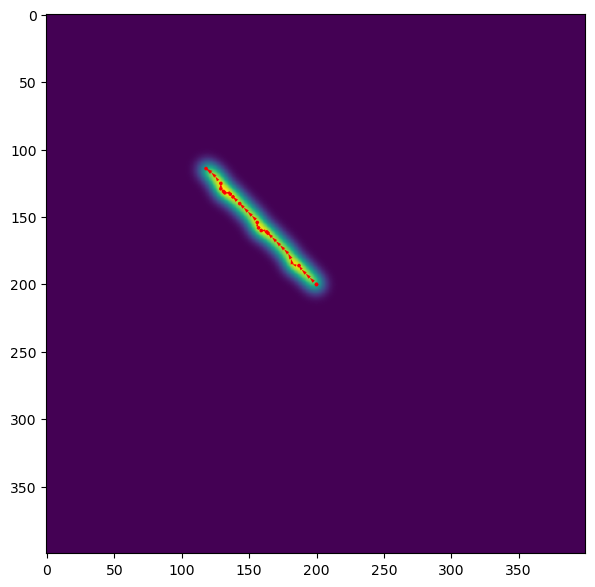

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def compute_direction_vectors_from_points(points):
    # Calculate the differences between consecutive points
    diffs = torch.cat([points[1:] - points[:-1], torch.zeros(1, 2)], dim=0)
    return points, diffs

# Create a sample tensor of 2D trajectory points
#trajectory_points = torch.tensor([[40, 40], [40, 41], [41, 42], [42, 43], [43, 44], [44, 45], [45, 45], [46, 46], [47, 46], [48, 47], [49, 47], [50, 48], [51, 49], [52, 49], [53, 50], [54, 50], [55, 51], [56, 52], [57, 53], [58, 53], [59, 54]])
probability_map = create_gaussian_mask(trajectory_mask, 43, 5.1)

coords, directions = compute_direction_vectors_from_points(trajectory.int())

# Extract X, Y positions from the coords tensor and U, V components from the directions tensor
X = coords[:, 0].numpy()
Y = coords[:, 1].numpy()
U = directions[:, 0].numpy()
V = directions[:, 1].numpy()

plt.figure(figsize=(7, 7))
plt.imshow(probability_map)
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='r')  # plot vector field
plt.show()
